In [1]:
#WARNING TRACK OPTION NEEDS SIGNIFICANT MEMORY
import sys
import json
import time
import os

In [2]:
import pandas as pd

In [3]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix
from scipy.sparse import lil_matrix
from scipy.sparse import hstack
from scipy.sparse import vstack
from scipy.sparse.linalg import svds
import scipy.sparse
import matplotlib.pyplot as plt
import csv
import operator

In [8]:
data_location_desktop = "/home/ubutubiggerbetter/shared/data/spotify_data/data/new_formatted_data"
data_location_laptop = "/media/sf_VMDropBox/spotify_data/data/new_formatted_data"
data_location_laptop = "/media/sf_VMDropBox/spotify_data/data/tmp_test"
data_location = data_location_laptop
save_location = data_location
NUM_PLAYLISTS = 1000000
NUM_TRACKS = 2262292
NUM_ARTISTS = 295860 #<- from stats.txt


isdir = os.path.isdir(data_location)
if isdir == False:
    print(data_location, ' does not exist')


In [9]:
#Helpful commands:
#type() tells type
#sys.getsizeof(obj) tell size in bytes of obj


In [10]:
def convert_to_full_charmat(artist_count, num_files, data_location, artist_mat = True):
    if artist_mat == True:
        full_mat_csc = csc_matrix((artist_count, 1000 * num_files))
    else:
        full_mat_csc = csc_matrix((artist_count, 1000 * num_files), dtype=np.uint8)
        full_mat_csc = full_mat_csc.tolil()
    inc = 0;
    filenum = 1;
    start_time = time.time()
    for i in range(0, num_files):
        #gen filename:
        if artist_mat == True:
            fname = 'charmat_pt_'+str(i)+'.npz'
            print('Loading ', fname)
            sparse_mat = scipy.sparse.load_npz(os.sep.join((data_location, fname)))
            sparse_mat = sparse_mat.astype(np.uint16)
            full_mat_csc[:, inc:(inc+1000)] = sparse_mat
        else:
            fname = 'track_charmat_pt_'+str(i)+'.npz'
            print('Loading ', fname)
            sparse_mat = scipy.sparse.load_npz(os.sep.join((data_location, fname)))
            sparse_mat = sparse_mat.astype(np.uint8)
            full_mat_csc[:, inc:(inc+1000)] = sparse_mat.tolil()

        inc = inc + 1000;
        print('Elapsed Time: ', (time.time() - start_time)/60, ' minutes')
    if artist_mat == True:
        return full_mat_csc
    else:
        full_mat_csc = full_mat_csc.astype(np.float64)
        return full_mat_csc.tocsc()


In [11]:
#Read individual files into one big char mat
full_char_mat = convert_to_full_charmat(NUM_ARTISTS, 4, data_location)
scipy.sparse.save_npz(os.sep.join((save_location, 'full_char_mat')), full_char_mat)


Loading  charmat_pt_0.npz
Elapsed Time:  0.044673724969228105  minutes
Loading  charmat_pt_1.npz
Elapsed Time:  0.10319411357243856  minutes
Loading  charmat_pt_2.npz
Elapsed Time:  0.16524321635564168  minutes
Loading  charmat_pt_3.npz
Elapsed Time:  0.21487123966217042  minutes


(295860, 4000)
Elapsed:  5.558617353439331


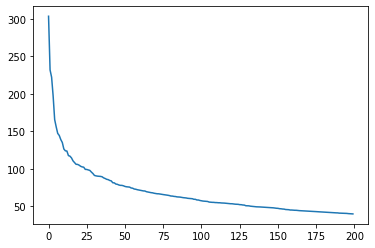

In [12]:
#Perform SVD:
kval = 200
start_time = time.time()
print(full_char_mat.shape)
U, S, VT = svds(full_char_mat, k = kval)
#Save the result:
Usparse = csc_matrix(U)
Ssparse = csc_matrix(S)
VTsparse = csc_matrix(VT)
scipy.sparse.save_npz(os.sep.join((save_location, 'U')), Usparse)
scipy.sparse.save_npz(os.sep.join((save_location, 'S')), Ssparse)
scipy.sparse.save_npz(os.sep.join((save_location, 'VT')), VTsparse)
print('Elapsed: ', time.time() - start_time)
plt.plot(S[::-1])
plt.show()


In [14]:
#Perform Multiplication to check how close the decomposition 
#matches the original matrix (optional)
'''start_time = time.time()
Usparse = csc_matrix(U[:, 0:kval])
VTsparse = csc_matrix(VT[0:kval, :])
Ssparse = csc_matrix(np.diag(S))
print(Usparse.shape)
print(VTsparse.shape)
print(Ssparse.shape)
mat1 = Usparse * Ssparse * VTsparse
print(mat1.shape)
mat_diff = full_char_mat - mat1
print("elapsed: ", time.time() - start_time)
print("Difference amount: ", mat_diff.sum())'''

(295860, 200)
(200, 4000)
(200, 200)
(295860, 4000)
elapsed:  29.2674822807312
Difference amount:  23563.052070649577


In [15]:
#Flip matrices so that S is in descending order
S_sorted = S[::-1]
n = len(S)
U[:,0:n] = U[:, n-1::-1]
VT[0:n, :] = VT[n-1::-1,:]
print(VT.shape)
#VT is latent_factors x playlists


#if I have a query playlist, it's going to have artists in it giving it information
#if it's SVD'd with the rest of them...

(200, 4000)


In [16]:
# Recover Artist INformation
artist_file = os.sep.join((data_location, "artist_index_new.csv"))
artist_dict= {}
art_index_dict = {}
fobj = open(artist_file, "r")
w = csv.DictReader(fobj)
for row in w:
    artist_dict[row['artist_name']] = row['index']
    art_index_dict[row['index']] = row['artist_name']
fobj.close()  

#Recover Playlist Information:
playlist_file = os.sep.join((data_location, "playlistname_index_new.csv"))
playlist_dict= {}
pl_index_dict = {}
fobj = open(playlist_file, "r")
w = csv.DictReader(fobj)
for row in w:
    playlist_dict[row['playlist_name']] = row['index']
    pl_index_dict[row['index']] = row['playlist_name']
fobj.close()

In [17]:
#Get first column of U [Artist to latent factors]
latent_factor_count = 50
top_values = 10
for i in range(0, latent_factor_count):
    
    artist_latentfactors = U[:, i]
    playlist_latentfactors = VT[i, :]
    #Get max assoiciated values
    #sorted_indices_art = np.argsort(np.abs(artist_latentfactors)
    #sorted_vals_art = np.sort(np.abs(artist_latentfactors))
                                    
    #ascending_indices_art = np.argsort(np.abs(artist_latentfactors))
    #ascending_indices_pl = np.argsort(np.abs(playlist_latentfactors))
    ascending_indices_art = np.argsort(artist_latentfactors)
    ascending_indices_pl = np.argsort(playlist_latentfactors)
    sorted_indices_art = ascending_indices_art[::-1]
    sorted_indices_pl = ascending_indices_pl[::-1]
    
    #sorted_indices_pl = np.argsort(playlist_latentfactors)
    
    #ascending_indices_art = sorted_indices_art[::-1]
    #ascending_indices_pl= sorted_indices_pl[::-1]
    artist_count = len(sorted_indices_art)
    #Now, find the associated artists:
    print('\n\nTop', top_values, ' Artist/Playlist Name for latent factor ', i, ':')
    print('Best Artists:')
    for j in range(0, top_values):
        artist = art_index_dict[str(sorted_indices_art[j])]
        
        print(artist, end=', ')
    print('\nAssociated Names: ')
    for j in range(0, top_values):
        playlist_name = pl_index_dict[str(sorted_indices_pl[j])]
        print(playlist_name, end=', ')



Top 10  Artist/Playlist Name for latent factor  0 :
Best Artists:
The Dead Rabbitts, In Dying Arms, Moments Till Fall, Wearing Thin, Secret Eyes, Earthists., Nights, Keyes, The Afterimage, Avant Garde, 
Associated Names: 
Back To School, Rap_17, indo, lolo, Türkçe Slow, karaoke., EME, CARDIO, Monsta X, Symphony, 

Top 10  Artist/Playlist Name for latent factor  1 :
Best Artists:
Drake, Future, Bryson Tiller, PARTYNEXTDOOR, Migos, Gucci Mane, Travis Scott, Russ, Roy Woods, A Boogie Wit da Hoodie, 
Associated Names: 
Drake_1, Drake, Drake_2, Rap_8, Jesse, r&b, turnip, New ish, Bet, OH MAN, 

Top 10  Artist/Playlist Name for latent factor  2 :
Best Artists:
The Beatles, George Martin, Pink Floyd, Elton John, Queen, The Rolling Stones, Led Zeppelin, Ed Sheeran, Billy Joel, John Mayer, 
Associated Names: 
Beatles, the beatles , Classics_3, Abby, oldies_2, Old_1, Wedding_4, Dad Rock, Good Feels, 70's, 

Top 10  Artist/Playlist Name for latent factor  3 :
Best Artists:
Drake, Eminem, The Be

The Weeknd, Beyoncé, Glee Cast, Imagine Dragons, Mumford & Sons, Florida Georgia Line, Ed Sheeran, NF, Lecrae, The Chainsmokers, 
Associated Names: 
Beyoncé , Chill_35, Glee Cast, Christian rap, Christmas_16, my country, Now_1, vol.2, // Drive, christian, 

Top 10  Artist/Playlist Name for latent factor  35 :
Best Artists:
Florida Georgia Line, Zac Brown Band, Lady Antebellum, Kendrick Lamar, The Weeknd, blink-182, J. Cole, Luke Bryan, Dierks Bentley, Chris Brown, 
Associated Names: 
my country, Country_71, Country_32, Kendrick Lamar , Country_52, woo, Country_12, Work_5, country_24, fire_1, 

Top 10  Artist/Playlist Name for latent factor  36 :
Best Artists:
blink-182, Rise Against, Breaking Benjamin, Kanye West, The Weeknd, NEEDTOBREATHE, Hillsong United, Lana Del Rey, Lil Uzi Vert, Panic! At The Disco, 
Associated Names: 
Rock_10, woo, Glory, Yeezy Taught Me, 💸💸, The PLayliSt, eh, Jammin_1, jamzzz, vibes, 

Top 10  Artist/Playlist Name for latent factor  37 :
Best Artists:
Kanye Wes

In [18]:
def recommend_on_playlist(query_playlist_index, pl_index_dict, VT, full_char_mat, latentfactors_to_use = 3, playlists_to_use = 20, top_artists = 10):
    print('playlist_name: ', pl_index_dict[str(100)])
    #get the max latent factors index assocaited with the query
    asc_sorted_indices_pl = np.argsort(VT[:,query_playlist_index])
    sorted_indices_pl = asc_sorted_indices_pl[::-1]

    #Use the sorted_indices_pl to map into applicable artists (U)
    recommended_artists = {}
    playlists_used = {}
    MAX_PLAYLISTS = VT.shape[1]
    k = 0
    full_char_mat = full_char_mat.tolil()
    for i in range(0, latentfactors_to_use):
        print(i, ' out of ', latentfactors_to_use)
        #Get the max latent factor index
        latent_factor_i = sorted_indices_pl[i]
        #Get all the playlists' latent factor for this index (corresponds to a given genre)
        latent_factors_v_playlists = VT[latent_factor_i, :]
        #Get the largest values which will be largest latent factors corresponding
        #to this genre
        asc_similar_playlist_indices = np.argsort(latent_factors_v_playlists)
        similar_playlist_indices = asc_similar_playlist_indices[::-1]
    
        playlists_to_use_loop = playlists_to_use
        k = 0
        while k < playlists_to_use_loop:
            #Make sure it's not the query playlist:
            if similar_playlist_indices[k] != query_playlist_index and str(similar_playlist_indices[k]) not in playlists_used:
                print('Similar Playlist is: ', pl_index_dict[str(similar_playlist_indices[k])])
                #Add to the dictionary (so we don't redo)
                playlists_used[str(similar_playlist_indices[k])] = pl_index_dict[str(similar_playlist_indices[k])]
                #get the index; this will be the most similar playlist for the largest latent
                #factor of the query playlist (for now)
                similar_playlist_index = similar_playlist_indices[k]
                #Map the index into original charmat to get similar artists:
                playlists_artists_indices = full_char_mat[:, similar_playlist_index]
            
                #Tally the most similar artists
                non_zero_artist_indices = playlists_artists_indices.nonzero()
                for j in non_zero_artist_indices[0]:
                    nz_index = j
                    if art_index_dict[str(nz_index)] in recommended_artists:
                        recommended_artists[art_index_dict[str(nz_index)]] = recommended_artists[art_index_dict[str(nz_index)]] + 1
                    else:
                        recommended_artists[art_index_dict[str(nz_index)]] = 1
            else:
                if playlists_to_use_loop + 1 < MAX_PLAYLISTS:
                    playlists_to_use_loop = playlists_to_use_loop + 1
            k = k+1
    
    sorted_dict = sorted(recommended_artists.items(), key=operator.itemgetter(1), reverse=True)
    top_recommended_artists = []
    i = 0
    for key, val in sorted_dict:
        if i >= top_artists:
            break
        top_recommended_artists.append(key)
        i = i+1
    return top_recommended_artists

In [19]:
recommend_on_playlist(100, pl_index_dict, VT, full_char_mat, 3, 5)

playlist_name:  Disneyland
0  out of  3
Similar Playlist is:  Study_2
Similar Playlist is:  Classical_1
Similar Playlist is:  Movie Soundtracks
Similar Playlist is:  Movie music
Similar Playlist is:  no lyrics
1  out of  3
Similar Playlist is:  Get Lucky_1
Similar Playlist is:  Default
Similar Playlist is:  disney
Similar Playlist is:  Gaming Playlist
Similar Playlist is:  study time 
2  out of  3
Similar Playlist is:  Disney_11
Similar Playlist is:  Girls_1
Similar Playlist is:   Frozen
Similar Playlist is:  Disney_12
Similar Playlist is:  musicals


['Hans Zimmer',
 'Thomas Newman',
 'Alan Menken',
 'John Williams',
 'Michael Giacchino',
 'Various Artists',
 'Danny Elfman',
 'Angela Lansbury',
 'Richard White',
 'Demi Lovato']

In [ ]:
print(VT.shape)